# **Mô hình XGBoost**

## **Thư viện**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.dates as mdates
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

## **Dữ liệu**

In [2]:
file_path = "..//data//processed//EUR_VND_Exchange_Rate_2020_2025_clean.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df[['Sell']]
data.head()



,Sell
Date,
2020-04-01,26506.55
2020-04-02,26506.55
2020-04-03,25936.23
2020-04-04,25936.23
2020-04-05,25936.23


## **Tạo đặc trưng**

In [3]:
def create_lag_features(series, lag=30):
    df_lag = pd.DataFrame()
    for i in range(lag):
        df_lag[f"lag_{i+1}"] = series.shift(i+1)
    df_lag["target"] = series.values
    return df_lag.dropna()

lag = 30
df_lagged = create_lag_features(data['Sell'], lag=lag)


## **Chia dữ liệu**

In [6]:
X = df_lagged.drop(columns="target").values
y = df_lagged["target"].values
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size=0.2)
val_timestamps = df_lagged.index[-len(y_val):]

## **Tìm siêu tham số tốt nhất**

In [5]:
model_dir = os.path.join("..", "model", "XGBoost")
os.makedirs(model_dir, exist_ok=True)


In [7]:
def train_xgb(X_train, y_train, model_path):
    param_grid = {
        'n_estimators': [100, 350],
        'max_depth': [3, 6],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'reg_alpha': [0],
        'reg_lambda': [1]
    }
    model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    joblib.dump(best_model, model_path)
    return best_model

model_path = r"..\model\XGBoost\best_xgboost.pkl"
best_model = train_xgb(X_train, y_train, model_path)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [8]:
model_path = r"..\model\XGBoost\best_xgboost.pkl"
best_model = train_xgb(X_train, y_train, model_path)
best_model.get_params()

Fitting 5 folds for each of 8 candidates, totalling 40 fits


{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

## **Dự đoán trên tập val**

In [9]:
y_pred_val = best_model.predict(X_val)


## **Đánh giá mô hình**

In [10]:
mae = mean_absolute_error(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred_val)
mape = mean_absolute_percentage_error(y_val, y_pred_val) * 100

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")
print(f"MAPE: {mape:.4f}%")


MAE: 78.3108
MSE: 15521.2398
RMSE: 124.5843
R2: 0.9481
MAPE: 0.2794%


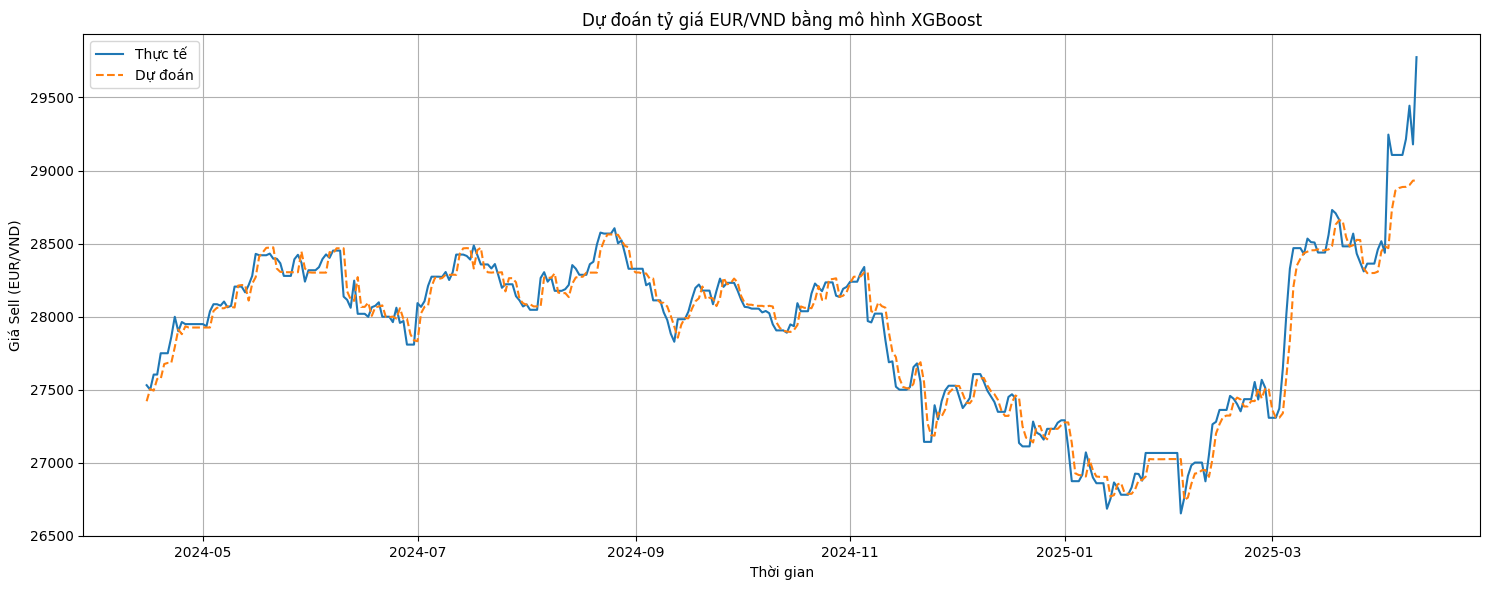

In [11]:
plt.figure(figsize=(15,6))
plt.plot(val_timestamps, y_val, label="Thực tế")
plt.plot(val_timestamps, y_pred_val, label="Dự đoán", linestyle="dashed")
plt.xlabel("Thời gian")
plt.ylabel("Giá Sell (EUR/VND)")
plt.title("Dự đoán tỷ giá EUR/VND bằng mô hình XGBoost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
from datetime import timedelta
last_row = df_lagged.iloc[-1]
last_date = df.index[-1]

current_lags = last_row.drop('target').values.reshape(1, -1)

predictions = []
prediction_dates = []

for i in range(7):
    # Dự đoán ngày i
    pred = best_model.predict(current_lags)[0]
    predictions.append(pred)

    pred_date = last_date + timedelta(days=i+1)
    prediction_dates.append(pred_date)

    # Cập nhật lags cho ngày tiếp theo
    current_lags = np.roll(current_lags, shift=1, axis=1)
    current_lags[0, 0] = pred

df_predictions = pd.DataFrame({
    'Ngày': prediction_dates,
    'Giá Sell dự đoán': predictions
})

print(df_predictions)


        Ngày  Giá Sell dự đoán
0 2025-04-12      28931.103516
1 2025-04-13      28908.351562
2 2025-04-14      28886.976562
3 2025-04-15      28883.492188
4 2025-04-16      28869.792969
5 2025-04-17      28877.121094
6 2025-04-18      28876.132812
